###  Aronの学習ノート 
***


# Markov Chain Monte Carlo Method

## Monte Carlo 法(Sampling Method)

- はシミュレーションや数値計算を乱数を用いて行う手法の総称。
- 是指使用随机数（或更常见的伪随机数）来解决很多计算问题的方法。

## Monte Carlo 積分

- 以下の期待値は解析的方法を用いて厳密に評価出来ないと仮定する。$p(x)$は確率密度関数。

$$\mathbb{E}(f)=\int f(x)p(x)dx.\tag{1}$$

- $p(x)$からのサンプルを独立にN個生成して$\mathbb{E}(f)$を近似できる。

$$\mathbb{E}(f)\approx\frac{1}{N}\sum_{n=1}^{N} f(x_n)\tag{2}$$

- 任意の関数$f(x)$の積分をモンテカルロ法で求める

$$\int_a^bf(x)dx\tag{3}$$

式(1)と違って分布の確率密度関数$p(x)$が入ってない。
以下のように式変換する。

$$ {(a-b)}\int_a^bf(x)\frac{1}{a-b}dx= (a-b)\int_a^bf(x)p(x)dx\tag{4}$$

$p(x)$は区間(a, b)での一様分布。

## モンテカルロ法で円周率

一番簡単なモンテカルロ法の応用

### 1. 一般的なモンテカルロ法

[https://mathtrain.jp/montecarlo](https://mathtrain.jp/montecarlo)

半径１の1/4の円の面積は$\frac{\pi}{4}$, 横軸座標X縦軸座標をYが一様分布の確率変数とすれば、たくさんの点（サンプリング）を生成。点が円の中に入る確率は$\frac{\pi}{4}$なので、$\pi$=円の中に入った点の数割る点の総数。

### 2. モンテカルロ積分で円周率

[http://aidiary.hatenablog.com/entry/20140728/1406555863](http://aidiary.hatenablog.com/entry/20140728/1406555863)
    
 半径１の1/4 円の公式は$$y=\sqrt{1-x^2}、ｘ\in[0,1]$$この1/4の円の面積を積分で計算すると$$\int_{0}^{1}\sqrt{1-x^2}dx=\frac{\pi}{4}$$
 この積分にモンテカルロ積分を適用すると$$(1-0)\int_{0}^{1}\sqrt{1-x^2}(\frac{1}{1-0})dx$$、ここで$\frac{1}{1-0}$は[0,1]の一様分布の確率密度関数である。なので、この積分を以下のように近似計算できる。
    
$$\begin{align*}
\frac{\pi}{4}&=(1-0)\int_{0}^{1}\sqrt{1-x^2}(\frac{1}{1-0})dx  \approx  \frac{1}{N}\sum\limits_i^N\sqrt{1-x_i^2}\\
\pi&\approx \frac{4}{N}\sum\limits_{i=1}^N\sqrt{1-x_i^2}\end{align*}$$
  
    

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ff = lambda x: np.sqrt(1-(x**2))

pi_1_array = []
pi_2_array = []
X = np.array([])
Y = np.array([])
step_size = 10000
for i in range(100):
    X = np.append(X, np.random.uniform(size = step_size))
    Y = np.append(Y, np.random.uniform(size = step_size))
    count_in_circle = 0
    for p0, p1 in zip(X, Y):
#         print(p0, p1)
        if (p0*p0 + p1*p1 <=1):
            count_in_circle +=1

#     print(len(in_pt))

    pi_1 = 4 * count_in_circle/ len(X)
    pi_2 = 4 * np.mean(ff(X))
    
    pi_1_array.append(pi_1)
    pi_2_array.append(pi_2)

## $\pi$の値の推移

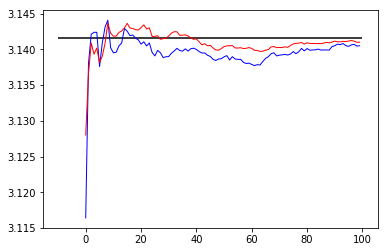

In [3]:
plt.plot(range(100), pi_1_array, lw=1,color='b')
plt.plot(range(100), pi_2_array, lw=1,color='r')
plt.hlines(np.pi, -10, 100 )
plt.show()

## 二乗誤差の推移

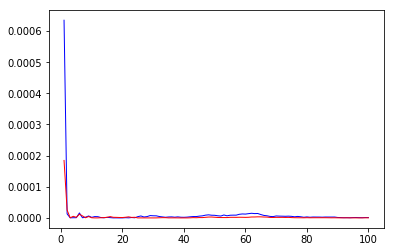

In [4]:
pi_1_square_err_array = [(p-np.pi)**2 for p in pi_1_array]
pi_2_square_err_array = [(p-np.pi)**2 for p in pi_2_array]
plt.plot(range(1,101), pi_1_square_err_array, lw=1,color='b')
plt.plot(range(1,101), pi_2_square_err_array, lw=1,color='r')

plt.show()


## 様々な分布に従う乱数を発生させる問題

- $X\sim~U(0,1)$は既に実装済み

- 任意の分布$p(x)$を従うサンプルをどうやって発生させる？（$U$を使って）

### 逆関数法

$$Y=g(X)$$
$$X=h(Y)$$
gとhは互いに逆関数である
$$X\sim U(0,1)$$
$$Y\sim f(h(y))\cdot |h'(y)|$$

$g(x)$をデザインすることで様々な分布を得られる。

### Box-Muller法

生成高斯分布

$$Z= \sqrt{-2\ln X} cos2 \pi Y\tag{5}\\
X, Y\sim U(0,1)\\Z\sim N(0, 1)$$

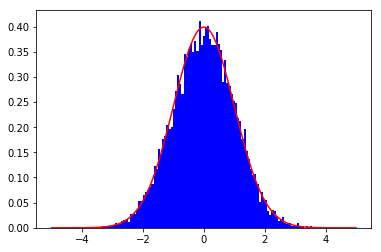

In [5]:
boxmuller = lambda x, y: np.sqrt(-2 * np.log(x)) * np.sin(2* np.pi * y)
def boxmuller_test(sample_size):
    xs = np.random.uniform(size = sample_size)
    ys = np.random.uniform(size =sample_size)
    norm = lambda x: 1/(np.sqrt(2 * np.pi)) * np.exp(-x**2/2)
    xx_ = np.linspace(-5.0,  5.0, 1000)
    yy_ = norm(xx_)
    plt.plot(xx_,yy_,color="r")
    plt.hist(boxmuller(xs, ys), bins=100, normed=True, color="b")
    plt.show()
#     print(len(z))
#     print(np.std(z))
boxmuller_test(10000)

### 棄却サンプリング

http://aidiary.hatenablog.com/entry/20140712/1405165815

### 重点サンプリング

## MCMC
***

### 马尔科夫链

随机过程满足以下条件
$$P(x^{(t+1)}=j|x^{(0)}=i_0, x^{(1)}=i_1, ...,x^{(t-1)}=i_{t-1}, x^{(t)}=i )=P(x^{(t+1)}=j|x^{(t)}=i)$$

- **马尔科夫性**： t+1时刻的状态只依赖t时刻的状态

例：
http://blog.csdn.net/shenxiaoming77/article/details/41805551

马尔科夫链经过有限次转移后可以得到稳定的分布。

#### 问题：

 - 稳定分布可能有多个
 - 怎样获取收敛于给定分布p的马尔科夫链(**任务**)

#### 收敛于p的充分条件: 
- 细致平稳条件
- 詳細釣り合い条件
    $$p(i)T(i, j)=p(j)T(j, i)\tag{5} \\T是转移概率：T(i, j)=p(j|i)$$
    
これを利用してTをうまく設計すれば、様々な分布からのサンプリングができる

## MH（Metropolis-Hastings）法

### 描述

 1. 任意取初始值$x^{(0)}$
 1. 对于时刻t=0, 1, 2, 3, ...重复以下步骤
 
     （i） 使用提案分布$q(y|x)$生成$y$
     
     （ii） 使用均匀分布$U(0, 1)$生成$u$
     $$x^{(t+1)}=\left\{\begin{align*}&y  & & u \leq \alpha(x^{(t)}, y)\\&x^{(t)} & &其他 \end{align*}\right. \tag{6}$$
     
     
其中
 $$\alpha(x, y) = min\left\{1, \frac{\pi(y)q(x|y)}{\pi(x)q(y|x)}\right\}\tag{7}$$
 $\pi $是稳定分布， $q$是提案分布，$\alpha$是接受率
 
 
 ### 收敛证明
 
 设$T(x,y)=q(y|x)\alpha(x, y)$,于是
 $$\begin{align*}\\
 \pi(x)T(x,y)&=\pi(x)q(y|x)\alpha(x, y)\\
 &=\pi(x)q(y|x)min\left\{1, \frac{\pi(y)q(x|y)}{\pi(x)q(y|x)}\right\}\\
 &=min\left\{\pi(x)q(y|x), \pi(y)q(x|y)\right\}\end{align*}\tag{8}$$
 
 而
 
 $$\begin{align*}\\
 \pi(y)T(y,x)&=\pi(y)q(x|y)\alpha(y, x)\\
 &=\pi(y)q(x|y)min\left\{1, \frac{\pi(x)q(y|x)}{\pi(y)q(x|y)}\right\}\\
 &=min\left\{\pi(y)q(x|y), \pi(x)q(y|x)\right\}\end{align*}\tag{9}$$
 
 所以得到
 
 $$ \pi(x)T(x,y)
=\pi(y)T(y,x)\tag{10}$$

满足细致平稳条件， 因此，MH算法得到的马尔科夫链收敛于分布$\pi$
 

### 编程实现 

#### 目标分布(平稳分布，不变分布)： 

- 给出以下混合高斯分布作为目标分步
- 生成服从目标分布的随机数

$$f(x) = r_1 \frac{1}{\sqrt{2\pi}\sigma_1}\exp{\left[\frac{(x-\mu_1)^2}{2\sigma_1^2}\right]} + r_2 \frac{1}{\sqrt{2\pi}\sigma_2}\exp{\left[\frac{(x-\mu_2)^2}{2\sigma_2^2}\right]}\tag{11}$$

$$\begin{align*}&混合率： &r_1=0.3, r_2=0.7, \\&方差： &\sigma_1^2=\sigma_2^2=\frac{1}{2}\\&平均： &\mu_1=1.0, \mu_2=-2.0\end{align*}$$

$$0.3* \frac{1}{\sqrt{\pi}}\exp{\left[(x-1)^2\right]} + 0.7 *\frac{1}{\sqrt{\pi}}\exp{\left[(x+2)^2\right]}\tag{12}$$

In [6]:
#target distribution , invariant distribution 
def target_dist(x):
    r = 0.3
    mu1 = 1.0
    mu2 = -2.0
    #方差=0.5
    x1 = x - mu1
    x2 = x - mu2
    e1 = np.exp(-x1 * x1) / np.sqrt(math.pi)
    e2 = np.exp(-x2 * x2) / np.sqrt(math.pi)
    return r * e1 + (1.0 - r) * e2

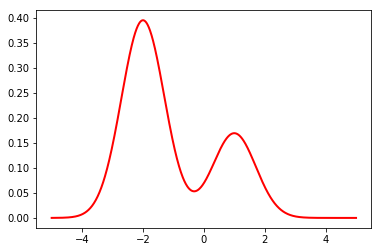

In [13]:
def plot_target_dist():
    x = np.linspace(-5.0,  5.0, 1000)
    y = target_dist(x)
    plt.plot(x, y, 'r-', lw=2)
    plt.show()
plot_target_dist()

#### 提案分布 proposal distribution

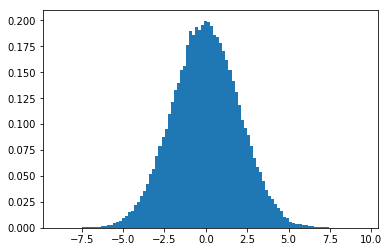

In [8]:
def prop_dist1(mu, sigma, **args):
    if "sample_size" in args:
        arr =  np.random.normal(mu, sigma, size=args["sample_size"])
        return arr
    else:
        return np.random.normal(mu, sigma)
# print(prop_dist1(0, 2, sample_size=100000))
plt.hist(prop_dist1(0, 2, sample_size=100000), bins=100, normed=True)
plt.show()

In [9]:
class MH():
    def __init__(self, init_x, target_dist, prop_sigma, proposal):
        self.x        = init_x
        self.target_dist = target_dist
        self.sigma    = prop_sigma
        self.prop_dist = proposal
 
    def update(self):
        candx = self.prop_dist(self.x, self.sigma)
        curp  = self.target_dist(self.x)
        candp = self.target_dist(candx)
        ratio = candp / curp if curp != 0.0 else 1.0
        alpha  = min(1.0, ratio)
        r = random.random()
        self.x = candx if r < alpha else self.x

In [10]:
def mh_test(init_x, trial, target_dist, proposal_dist):
    # instantiate M-H object
    burn = int(trial / 10)
    mh = MH(init_x, target_dist, 1.0, proposal_dist)
 
 
    # burn-in
    for i in range(burn):
        mh.update()
 
    # M-H simulation
    samples=[]
    for i in range(trial):
        samples.append(mh.x)
        mh.update()
    
    
    # 目标分布
    x = np.linspace(-5.0,  5.0, 1000)
    y = target_dist(x)
    plt.plot(x, y, 'r-', lw=2)
    
#     print(samples)
    #MH法生成的目标分布，直方图
    plt.hist(samples,color="blue", bins=100, normed=True)
    
    plt.show()


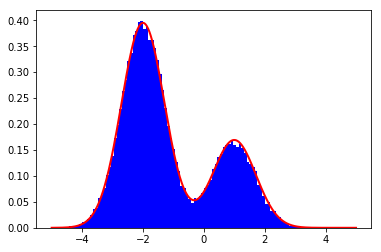

In [11]:
mh_test(0.0, 100000, target_dist, prop_dist1)

## Gibbs Sampling 法